In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [26]:
# define constants

sigma_B = 5.6696e-8 # W/(m^2 K^4)
sigma_B_scaled = 5.6696
solar_const = 1368 # W/m^2
r_earth = 6371e3 # m
area_earth = np.pi * r_earth**2
emissivity_earth = 1
transmissivity_atm = 0.63
albedo_sky = 0.2
albedo_surface = 0.4
albedo_ocean = 0.1
albedo_ice = 0.6
density_land = 2500 # kg/m^3
density_water = 1028 # kg/m^3
density_ice = 900 # kg/m^3
depth_land = 1 # m
depth_ocean = 70 # m
depth_ice = 1 # m
spec_heat_land = 790 # J kg/K
spec_heat_water = 4187 # J kg/K
spec_heat_ice = 2060 # J kg/K

# zonal properties
area_fractions = np.array([0.0670, 0.1830, 0.2500, 0.2500, 0.1830, 0.0670])
geometric_factors = np.array([0.1076, 0.2277, 0.3045, 0.3045, 0.2277, 0.1076])
land_fractions = [0.008, 0.0116, 0.2522, 0.3550, 0.5786, 0.0020]
ocean_fractions = [0.2901, 0.9880, 0.7472, 0.6442, 0.4176, 0.6310]
ice_fractions = [0.7019, 0.0004, 0.0006, 0.0008, 0.0038, 0.3670]

# zonal exchanges
lengths = np.array([2.0015e7, 3.4667e7, 4.0030e7, 3.4667e7, 2.0015e7]) # m
# k_vals = np.zeros(5)
k_vals = np.array([1e7, 1e7, 1e7, 5e7, 1e7]) # W / (m K)

# zonal exchanges
# lengths = np.array([[0, 2.0015e7, 0, 0, 0, 0],
#                     [2.0015e7, 0, 3.4667e7, 0, 0, 0],
#                     [0, 3.4667e7, 0, 4.0030e7, 0, 0],
#                     [0, 0, 4.0030e7, 0, 3.4667e7, 0],
#                     [0, 0, 0, 3.4667e7, 0, 2.0015e7],
#                     [0, 0, 0, 0, 2.0015e7, 0]]) # m
# k_vals = np.array([[0, 1e7, 0, 0, 0, 0],
#                     [1e7, 0, 1e7, 0, 0, 0],
#                     [0, 1e7, 0, 1e7, 0, 0],
#                     [0, 0, 1e7, 0, 5e7, 0],
#                     [0, 0, 0, 5e7, 0, 1e7],
#                     [0, 0, 0, 0, 1e7, 0]]) # W / (m K)

In [42]:
def compute_pcZ(p, c, z):
    return p * c * z

def compute_albedo(a):
    return a

def average_fcn(f, func, *args):
    """Takes in a list of length 3 for each of the input variables and returns 
    the weighted average based on the fraction f"""
    f = np.array(f)
    assert np.isclose(np.sum(f), 1.0), "Fractions must sum to 1"
    assert np.min(f) >= 0, "Fractions cannot be negative"

    total = 0
    for i in range(len(f)):
        # Pass the i-th element of each argument list into func
        total += f[i] * func(*[arg[i] for arg in args])
    return total

frac_arr = np.vstack([land_fractions, ocean_fractions, ice_fractions])
density_arr = np.array([density_land, density_water, density_ice])
spec_heat_arr = np.array([spec_heat_land, spec_heat_water, spec_heat_ice])
depth_arr = np.array([depth_land, depth_ocean, depth_ice])
albedo_arr = np.array([albedo_surface, albedo_ocean, albedo_ice])

avg_albedos = np.array([average_fcn(frac_arr[:,i], compute_albedo, albedo_arr) for i in range(frac_arr.shape[1])])
pcZ_vals = np.array([average_fcn(frac_arr[:,i], compute_pcZ, density_arr, spec_heat_arr, depth_arr) for i in range(frac_arr.shape[1])])

def compute_dT(temp):
    dT = (geometric_factors * (1 - albedo_sky) * (1 - avg_albedos) * solar_const - transmissivity_atm * sigma_B_scaled * (temp/100)**4) / pcZ_vals
    dT[:-1] += lengths * k_vals * (temp[1:] - temp[:-1]) / (area_earth * area_fractions[:-1] * pcZ_vals[:-1])
    dT[1:] -= lengths * k_vals * (temp[1:] - temp[:-1]) / (area_earth * area_fractions[1:] * pcZ_vals[1:])
    return dT

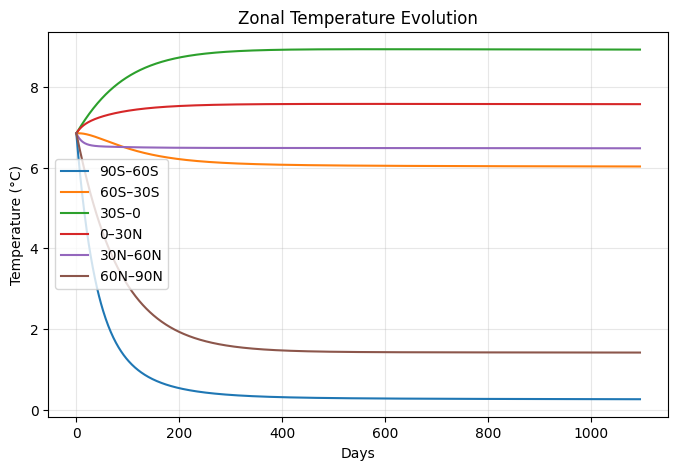

In [57]:
# Parameters
n_zones = 6
lat_labels = ['90S–60S', '60S–30S', '30S–0', '0–30N', '30N–60N', '60N–90N']
dt = 3600 * 24  # time step (seconds)
n_steps = 365 * 3 # years

# Initial temperature
temp = np.ones(6) * 280  # initial guess
temps_over_time = [temp.copy()]

# Time integration
for _ in range(n_steps):
    dT = compute_dT(temp)
    temp = temp + dT * dt
    temps_over_time.append(temp.copy())

temps_over_time = np.array(temps_over_time)
times = np.arange(len(temps_over_time))

# --- Plot 1: Time series of zonal temperatures ---
plt.figure(figsize=(8, 5))
for i, label in enumerate(lat_labels):
    plt.plot(times, temps_over_time[:, i] - 273.15, label=label)
plt.xlabel("Days")
plt.ylabel("Temperature (°C)")
plt.title("Zonal Temperature Evolution")
plt.legend()
plt.grid(alpha=0.3)
plt.show()